In [2]:
from collections import defaultdict
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from tqdm import tqdm

In [3]:
%matplotlib inline

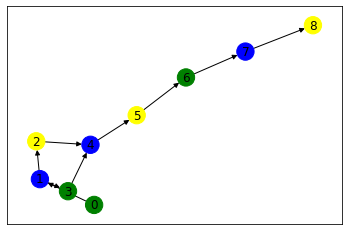

In [4]:
node_types = ['green', 'blue', 'yellow']

g = nx.DiGraph()

g.add_nodes_from([(i, {'type':node_types[i % len(node_types)]}) for i in range(9)])

g.add_edges_from([
    (0,1),
    (1,2),
    (1,3),
    (3,4),
    (2,4),
    (4,5),
    (5,6),
    (6,7),
    (7,8)
])

node_colors = [g.nodes[i]['type'] for i in g.nodes]

nx.draw_networkx(g, with_labels=True, node_color=node_colors)

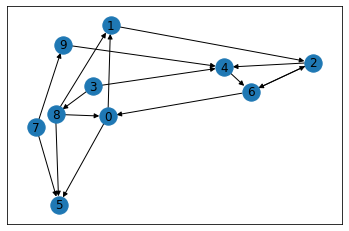

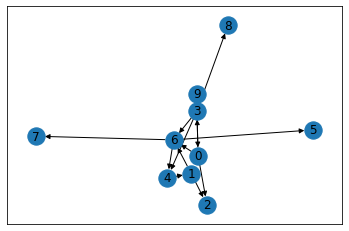

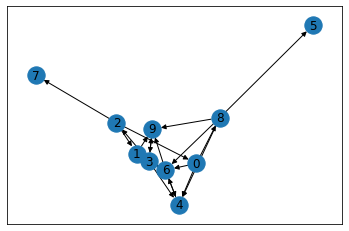

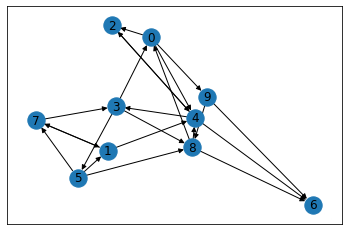

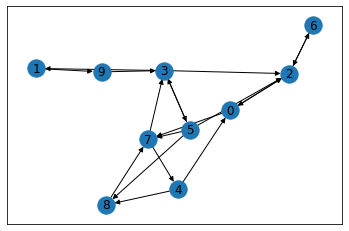

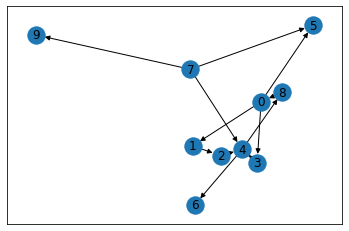

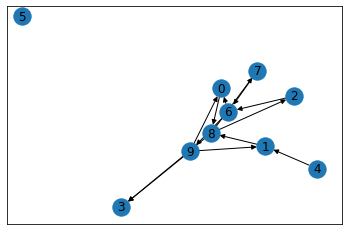

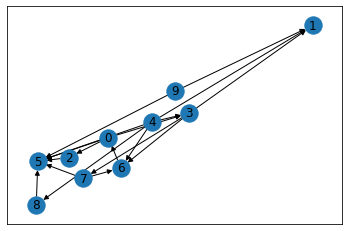

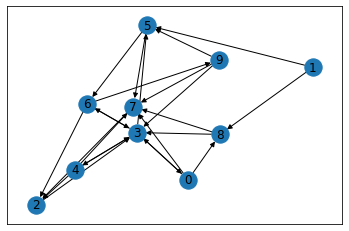

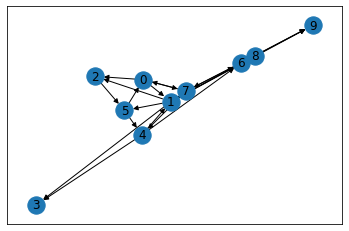

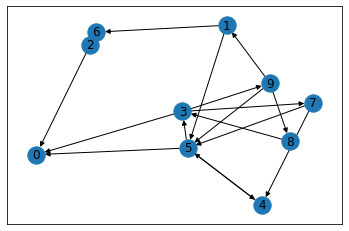

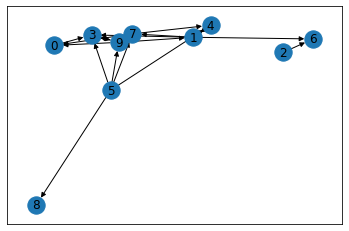

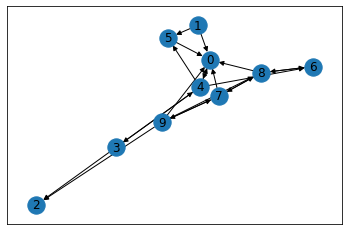

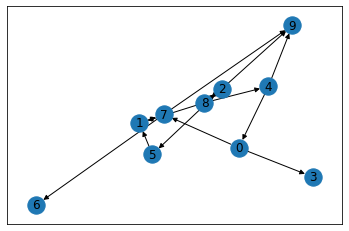

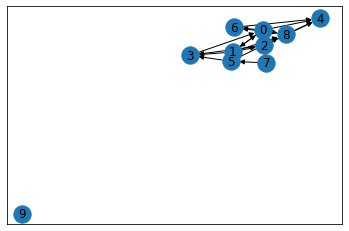

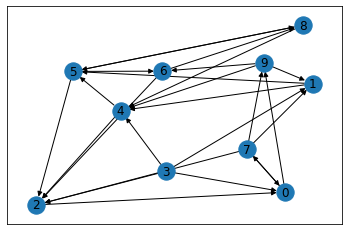

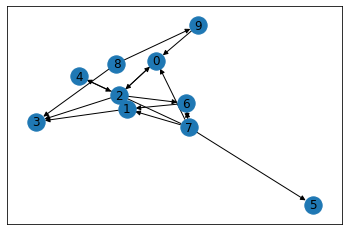

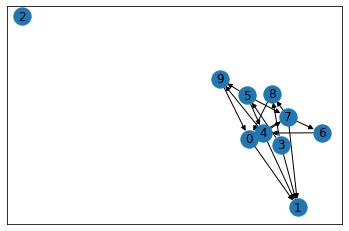

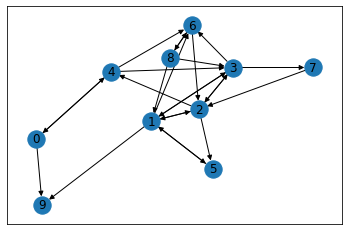

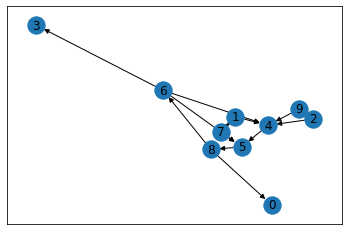

defaultdict(<class 'int'>, {True: 17, False: 3})


In [11]:
import matplotlib.pyplot as plt
G_list = []
stats = defaultdict(int)
for i in range(20):
    g = nx.erdos_renyi_graph(10,0.2, directed=True)

    stats[nx.is_weakly_connected(g)] += 1
    
    G_list.append(g)
    nx.draw_networkx(g)
    plt.show()
print(stats)

In [12]:
gdf_list = []
for i, g in enumerate(G_list):
    gdf = pd.DataFrame(list(g.edges), columns=['src_id', 'dst_id'])
    gdf['trace_id'] = i
    
    gdf_list.append(gdf)

edge_df = pd.concat(gdf_list)
edge_df

,src_id,dst_id,trace_id
0,0,1,0
1,0,5,0
2,1,2,0
3,2,4,0
4,2,6,0
...,...,...,...
10,7,5,19
11,8,0,19
12,8,6,19
13,9,2,19


In [13]:
gdf_list = defaultdict(list)
for i, g in tqdm(enumerate(G_list)):
    gdf_list['trace_id'].append(i)
    gdf_list['trace_bool'].append(nx.is_weakly_connected(g))
    gdf_list['error_trace_type'].append(nx.is_weakly_connected(g))

trace_info_df = pd.DataFrame(gdf_list)
trace_info_df

20it [00:00, 17523.73it/s]


,trace_id,trace_bool,error_trace_type
0,0,True,True
1,1,True,True
2,2,True,True
3,3,True,True
4,4,True,True
5,5,True,True
6,6,False,False
7,7,True,True
8,8,True,True
9,9,True,True


In [14]:
cols = ['trace_id', 'node_id', 'attr_0', 'attr_1', 'attr_2', 'attr_3', 'attr_4', 'attr_5',
       'attr_6', 'attr_7', 'attr_8', 'attr_9']

In [15]:
trace_node = defaultdict(list)
for i, g in enumerate(G_list):
    
    for n in list(g.nodes()):
        trace_node['trace_id'].append(i)
        trace_node['node_id'].append(n)
trace_nodes_df = pd.DataFrame(trace_node)

In [16]:
node_feature_list = []
for i, g in tqdm(enumerate(G_list)):
    incoming_edges = defaultdict(list)
    for e in list(g.in_edges):
        incoming_edges['node_id'].append(e[0])
        incoming_edges['inc'].append(e[1])

    incoming_edge_df = pd.DataFrame(incoming_edges)
    _node_feature_df = pd.get_dummies(incoming_edge_df, prefix='attr', columns=['inc']) \
        .groupby('node_id').sum().astype(float).reset_index()
    
    _node_feature_df.insert(0, 'trace_id', i)
    
    node_feature_list.append(_node_feature_df)
node_feature_df = pd.concat(node_feature_list)

node_feature_df = trace_nodes_df.merge(node_feature_df, on=['trace_id','node_id'], how='left')[cols] \
                    .fillna(0.0) \
                    .sort_values(['trace_id', 'node_id'])
node_feature_df

20it [00:00, 220.48it/s]


,trace_id,node_id,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9
0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,19,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
196,19,6,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
197,19,7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
198,19,8,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
from sklearn.preprocessing import normalize

In [18]:
node_feature_df.iloc[:,2:] = normalize(node_feature_df[cols[2:]], axis=0)
node_feature_df

,trace_id,node_id,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9
0,0,0,0.000000,0.164399,0.000000,0.000000,0.000000,0.162221,0.000000,0.0,0.000000,0.0
1,0,1,0.000000,0.000000,0.169031,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,0,2,0.000000,0.000000,0.000000,0.000000,0.149071,0.000000,0.156174,0.0,0.000000,0.0
3,0,3,0.000000,0.000000,0.000000,0.000000,0.149071,0.000000,0.000000,0.0,0.179605,0.0
4,0,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.156174,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,19,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.179605,0.0
196,19,6,0.000000,0.000000,0.000000,0.152499,0.149071,0.162221,0.000000,0.0,0.000000,0.0
197,19,7,0.000000,0.164399,0.000000,0.000000,0.000000,0.162221,0.000000,0.0,0.000000,0.0
198,19,8,0.156174,0.000000,0.000000,0.000000,0.000000,0.000000,0.156174,0.0,0.000000,0.0


In [19]:
node_feature_df[node_feature_df.trace_id==8]

,trace_id,node_id,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9
80,8,0,0.000000,0.0,0.000000,0.152499,0.000000,0.000000,0.000000,0.179605,0.179605,0.000000
81,8,1,0.000000,0.0,0.000000,0.000000,0.000000,0.162221,0.000000,0.000000,0.179605,0.000000
82,8,2,0.000000,0.0,0.000000,0.152499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
83,8,3,0.156174,0.0,0.000000,0.000000,0.149071,0.162221,0.156174,0.000000,0.000000,0.000000
84,8,4,0.000000,0.0,0.169031,0.152499,0.000000,0.000000,0.000000,0.179605,0.000000,0.000000
85,8,5,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.156174,0.179605,0.000000,0.000000
86,8,6,0.000000,0.0,0.169031,0.152499,0.000000,0.000000,0.000000,0.000000,0.000000,0.188982
87,8,7,0.000000,0.0,0.169031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
88,8,8,0.000000,0.0,0.000000,0.152499,0.000000,0.000000,0.000000,0.179605,0.000000,0.000000
89,8,9,0.000000,0.0,0.000000,0.152499,0.000000,0.162221,0.000000,0.179605,0.000000,0.000000


In [20]:
# output
output_root_dir = '../../HetGNN/ProcessedData_synth'
node_feature_df.to_csv(f'{output_root_dir}/node_feature_norm.csv', index=False)
edge_df.to_csv(f'{output_root_dir}/edge_index.csv', index=False)

trace_info_df.to_csv(f'{output_root_dir}/trace_info.csv', index=False)